# 01 - Business Understanding


Using Data Mining the aim is to idenity and predict the factors 
which affect the use of bike-sharing rental services 

# 02 -Data Exploration 

In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/24 17:42:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.csv('train.csv')

df_pd = pd.read_csv('train.csv')

In [3]:
df.show()

df.columns 

+-------------------+------+-------+----------+-------+-----+------+--------+---------+------+----------+-----+
|                _c0|   _c1|    _c2|       _c3|    _c4|  _c5|   _c6|     _c7|      _c8|   _c9|      _c10| _c11|
+-------------------+------+-------+----------+-------+-----+------+--------+---------+------+----------+-----+
|           datetime|season|holiday|workingday|weather| temp| atemp|humidity|windspeed|casual|registered|count|
|2011-01-01 00:00:00|     1|      0|         0|      1| 9.84|14.395|      81|        0|     3|        13|   16|
|2011-01-01 01:00:00|     1|      0|         0|      1| 9.02|13.635|      80|        0|     8|        32|   40|
|2011-01-01 02:00:00|     1|      0|         0|      1| 9.02|13.635|      80|        0|     5|        27|   32|
|2011-01-01 03:00:00|     1|      0|         0|      1| 9.84|14.395|      75|        0|     3|        10|   13|
|2011-01-01 04:00:00|     1|      0|         0|      1| 9.84|14.395|      75|        0|     0|         1

['_c0',
 '_c1',
 '_c2',
 '_c3',
 '_c4',
 '_c5',
 '_c6',
 '_c7',
 '_c8',
 '_c9',
 '_c10',
 '_c11']

In [4]:
df_pd.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


In [5]:
# rename columns 
df = df.withColumnRenamed('_c0', 'datetime')
df = df.withColumnRenamed('_c1', 'season')
df = df.withColumnRenamed('_c2', 'holiday')
df = df.withColumnRenamed('_c3', 'workday')
df = df.withColumnRenamed('_c4', 'weather')
df = df.withColumnRenamed('_c5', 'temp')
df = df.withColumnRenamed('_c6', 'feels_temp')
df = df.withColumnRenamed('_c7', 'humidity')
df = df.withColumnRenamed('_c8', 'windspeed')
df = df.withColumnRenamed('_c9', 'casual')
df = df.withColumnRenamed('_c10', 'registered')
df = df.withColumnRenamed('_c11', 'count')

df.show()



+-------------------+------+-------+----------+-------+-----+----------+--------+---------+------+----------+-----+
|           datetime|season|holiday|   workday|weather| temp|feels_temp|humidity|windspeed|casual|registered|count|
+-------------------+------+-------+----------+-------+-----+----------+--------+---------+------+----------+-----+
|           datetime|season|holiday|workingday|weather| temp|     atemp|humidity|windspeed|casual|registered|count|
|2011-01-01 00:00:00|     1|      0|         0|      1| 9.84|    14.395|      81|        0|     3|        13|   16|
|2011-01-01 01:00:00|     1|      0|         0|      1| 9.02|    13.635|      80|        0|     8|        32|   40|
|2011-01-01 02:00:00|     1|      0|         0|      1| 9.02|    13.635|      80|        0|     5|        27|   32|
|2011-01-01 03:00:00|     1|      0|         0|      1| 9.84|    14.395|      75|        0|     3|        10|   13|
|2011-01-01 04:00:00|     1|      0|         0|      1| 9.84|    14.395|

In [6]:
#Filter out initial row as it is column lable 
df = df.filter(df.datetime!='datetime')

df.show()

df.columns

+-------------------+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+
|           datetime|season|holiday|workday|weather| temp|feels_temp|humidity|windspeed|casual|registered|count|
+-------------------+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+
|2011-01-01 00:00:00|     1|      0|      0|      1| 9.84|    14.395|      81|        0|     3|        13|   16|
|2011-01-01 01:00:00|     1|      0|      0|      1| 9.02|    13.635|      80|        0|     8|        32|   40|
|2011-01-01 02:00:00|     1|      0|      0|      1| 9.02|    13.635|      80|        0|     5|        27|   32|
|2011-01-01 03:00:00|     1|      0|      0|      1| 9.84|    14.395|      75|        0|     3|        10|   13|
|2011-01-01 04:00:00|     1|      0|      0|      1| 9.84|    14.395|      75|        0|     0|         1|    1|
|2011-01-01 05:00:00|     1|      0|      0|      2| 9.84|     12.88|      75|   6.0032|     0| 

['datetime',
 'season',
 'holiday',
 'workday',
 'weather',
 'temp',
 'feels_temp',
 'humidity',
 'windspeed',
 'casual',
 'registered',
 'count']

In [7]:
#Dataframe Components Summary 

df.select("datetime", "season", 'holiday', 'workday').summary().show()
df.select('weather',"temp", "feels_temp", 'humidity', 'windspeed').summary().show()
df.select("casual", "registered", 'count',).summary().show()

+-------+-------------------+------------------+-------------------+------------------+
|summary|           datetime|            season|            holiday|           workday|
+-------+-------------------+------------------+-------------------+------------------+
|  count|              10886|             10886|              10886|             10886|
|   mean|               null|2.5066139996325556|0.02856880396839978|0.6808745177291935|
| stddev|               null|1.1161743093443237|0.16659885062470944|0.4661591687997361|
|    min|2011-01-01 00:00:00|                 1|                  0|                 0|
|    25%|               null|               2.0|                0.0|               0.0|
|    50%|               null|               3.0|                0.0|               1.0|
|    75%|               null|               4.0|                0.0|               1.0|
|    max|2012-12-19 23:00:00|                 4|                  1|                 1|
+-------+-------------------+---

In [8]:
df.printSchema()

df_pd.info()


root
 |-- datetime: string (nullable = true)
 |-- season: string (nullable = true)
 |-- holiday: string (nullable = true)
 |-- workday: string (nullable = true)
 |-- weather: string (nullable = true)
 |-- temp: string (nullable = true)
 |-- feels_temp: string (nullable = true)
 |-- humidity: string (nullable = true)
 |-- windspeed: string (nullable = true)
 |-- casual: string (nullable = true)
 |-- registered: string (nullable = true)
 |-- count: string (nullable = true)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8  

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|             10886|
|   mean|191.57413191254824|
| stddev|181.14445383028493|
|    min|                 1|
|    25%|              42.0|
|    50%|             145.0|
|    75%|             284.0|
|    max|                99|
+-------+------------------+



<AxesSubplot:ylabel='Frequency'>

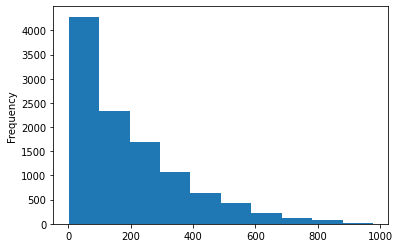

In [9]:
df.select('count').summary().show()
df_pd['count'].plot.hist()

<AxesSubplot:ylabel='season'>

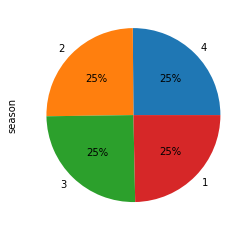

In [10]:
df_pd['season'].value_counts().plot.pie(autopct='%1.0f%%')

<AxesSubplot:ylabel='weather'>

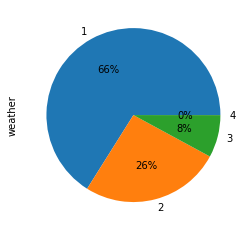

In [11]:
df_pd['weather'].value_counts().plot.pie(autopct='%1.0f%%')

<AxesSubplot:ylabel='workingday'>

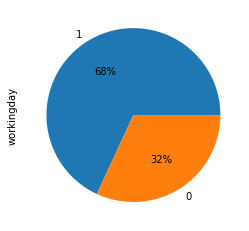

In [12]:
df_pd['workingday'].value_counts().plot.pie(autopct='%1.0f%%')

In [13]:
#Check if there are any null or missing values
from pyspark.sql.functions import col

null_counts = df.select([col(column).isNull().alias(column) for column in df.columns]).toPandas().sum()
print("Null value counts in DataFrame:")
print(null_counts)

Null value counts in DataFrame:
datetime      0
season        0
holiday       0
workday       0
weather       0
temp          0
feels_temp    0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


In [14]:
df.select('humidity', 'windspeed').summary().show()


+-------+------------------+------------------+
|summary|          humidity|         windspeed|
+-------+------------------+------------------+
|  count|             10886|             10886|
|   mean| 61.88645967297446|12.799395406945093|
| stddev|19.245033277394704|  8.16453732683871|
|    min|                 0|                 0|
|    25%|              47.0|            7.0015|
|    50%|              62.0|            12.998|
|    75%|              77.0|           16.9979|
|    max|                97|            8.9981|
+-------+------------------+------------------+



In [15]:
#Data Validaiton


#dealing with outliers in humidity and windspeed variables 

from pyspark.sql.functions import col, mean, stddev

# Calculate mean and std deviation for the 'humidity' column
stats = df.select(mean(col("humidity")).alias('mean_humidity'), 
                  stddev(col("humidity")).alias('stddev_humidity')).collect()

# Extract mean and std deviation values
mean_val = stats[0]['mean_humidity']
stddev_val = stats[0]['stddev_humidity']

# Define threshold for outliers (e.g., 3 standard deviations)
threshold = 3

# Filter out outliers based on the Z-score
df = df.filter((col("humidity") > mean_val - threshold * stddev_val) & 
                            (col("humidity") < mean_val + threshold * stddev_val))




In [16]:
df.select('humidity').summary().show()

+-------+-----------------+
|summary|         humidity|
+-------+-----------------+
|  count|            10864|
|   mean|62.01178203240059|
| stddev| 19.0617211232077|
|    min|               10|
|    25%|             47.0|
|    50%|             62.0|
|    75%|             77.0|
|    max|               97|
+-------+-----------------+



In [17]:
stats = df.select(mean(col("windspeed")).alias('mean_windspeed'), 
                    stddev(col("windspeed")).alias('stddev_windspeed')).collect()

# Extract mean and std deviation values
mean_val = stats[0]['mean_windspeed']
stddev_val = stats[0]['stddev_windspeed']

# Define threshold for outliers
threshold = 3.0  # Example threshold as a float

# Filter out outliers based on the Z-score using the threshold
df = df.filter((col("windspeed") > mean_val - threshold * stddev_val) & 
                            (col("windspeed") < mean_val + threshold * stddev_val))

In [18]:
df.select('windspeed').summary().show()

+-------+------------------+
|summary|         windspeed|
+-------+------------------+
|  count|             10798|
|   mean|12.610226486386713|
| stddev| 7.852936815637357|
|    min|                 0|
|    25%|            7.0015|
|    50%|            12.998|
|    75%|           16.9979|
|    max|            8.9981|
+-------+------------------+



# 03 - Data Preparation

In [19]:
# Import in the relevant types.
from pyspark.sql.types import (StructField,StringType,IntegerType,StructType)
df.show() 

+-------------------+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+
|           datetime|season|holiday|workday|weather| temp|feels_temp|humidity|windspeed|casual|registered|count|
+-------------------+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+
|2011-01-01 00:00:00|     1|      0|      0|      1| 9.84|    14.395|      81|        0|     3|        13|   16|
|2011-01-01 01:00:00|     1|      0|      0|      1| 9.02|    13.635|      80|        0|     8|        32|   40|
|2011-01-01 02:00:00|     1|      0|      0|      1| 9.02|    13.635|      80|        0|     5|        27|   32|
|2011-01-01 03:00:00|     1|      0|      0|      1| 9.84|    14.395|      75|        0|     3|        10|   13|
|2011-01-01 04:00:00|     1|      0|      0|      1| 9.84|    14.395|      75|        0|     0|         1|    1|
|2011-01-01 05:00:00|     1|      0|      0|      2| 9.84|     12.88|      75|   6.0032|     0| 

In [20]:
#Split datetime varaible into Year, Month, Day and Hour
from pyspark.sql.functions import split

split_col = split(df['datetime'], '-')

df = df.withColumn('Year', split_col.getItem(0))
df = df.withColumn('Month', split_col.getItem(1))
df = df.withColumn('Day_Time', split_col.getItem(2))


split_col = split(df['Day_Time'], '\s+')
df = df.withColumn('Day', split_col.getItem(0))
df = df.withColumn('Time', split_col.getItem(1))

split_col = split(df['Time'], ':')
df = df.withColumn('Hour', split_col.getItem(0))

df = df.drop('datetime')
df = df.drop('Day_Time')
df = df.drop('Time')
df.show() 


+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|season|holiday|workday|weather| temp|feels_temp|humidity|windspeed|casual|registered|count|Year|Month|Day|Hour|
+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|     1|      0|      0|      1| 9.84|    14.395|      81|        0|     3|        13|   16|2011|   01| 01|  00|
|     1|      0|      0|      1| 9.02|    13.635|      80|        0|     8|        32|   40|2011|   01| 01|  01|
|     1|      0|      0|      1| 9.02|    13.635|      80|        0|     5|        27|   32|2011|   01| 01|  02|
|     1|      0|      0|      1| 9.84|    14.395|      75|        0|     3|        10|   13|2011|   01| 01|  03|
|     1|      0|      0|      1| 9.84|    14.395|      75|        0|     0|         1|    1|2011|   01| 01|  04|
|     1|      0|      0|      2| 9.84|     12.88|      75|   6.0032|     0|         1|    1|2011

In [21]:
# Split then reintegrate dataset 
split_df = df.randomSplit([0.5, 0.5])

# Access the two resulting DataFrames
df_part1 = split_df[0]
df_part2 = split_df[1]

df_part1.show()
df_part2.show()



+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|season|holiday|workday|weather| temp|feels_temp|humidity|windspeed|casual|registered|count|Year|Month|Day|Hour|
+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|     1|      0|      0|      1|10.66|    11.365|      41|  19.9995|     0|        16|   16|2012|   03| 10|  03|
|     1|      0|      0|      1|10.66|    11.365|      44|  22.0028|    11|        20|   31|2011|   01| 02|  21|
|     1|      0|      0|      1|10.66|     12.12|      41|  16.9979|     9|        53|   62|2012|   03| 04|  22|
|     1|      0|      0|      1|10.66|     12.88|     100|   12.998|     3|        53|   56|2011|   02| 05|  21|
|     1|      0|      0|      1|10.66|     12.88|      41|   12.998|     6|        77|   83|2012|   03| 10|  23|
|     1|      0|      0|      1|10.66|     12.88|      41|  15.0013|     1|        39|   40|2011

In [22]:
df = df_part1.unionAll(df_part2)

df.show()



+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|season|holiday|workday|weather| temp|feels_temp|humidity|windspeed|casual|registered|count|Year|Month|Day|Hour|
+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|     1|      0|      0|      1|10.66|    11.365|      41|  19.9995|     0|        16|   16|2012|   03| 10|  03|
|     1|      0|      0|      1|10.66|    11.365|      44|  22.0028|    11|        20|   31|2011|   01| 02|  21|
|     1|      0|      0|      1|10.66|     12.12|      41|  16.9979|     9|        53|   62|2012|   03| 04|  22|
|     1|      0|      0|      1|10.66|     12.88|     100|   12.998|     3|        53|   56|2011|   02| 05|  21|
|     1|      0|      0|      1|10.66|     12.88|      41|   12.998|     6|        77|   83|2012|   03| 10|  23|
|     1|      0|      0|      1|10.66|     12.88|      41|  15.0013|     1|        39|   40|2011

In [23]:
#Reformt Schema
from pyspark.sql.types import StringType, IntegerType, FloatType, BooleanType

df.printSchema()

df = df.withColumn("season" ,df["season"].cast(IntegerType()))
df = df.withColumn("holiday" ,df["holiday"].cast(BooleanType()))
df = df.withColumn("workday" ,df["workday"].cast(BooleanType()))
df = df.withColumn("weather" ,df["weather"].cast(IntegerType()))
df = df.withColumn("temp" ,df["temp"].cast(FloatType()))
df = df.withColumn("feels_temp" ,df["feels_temp"].cast(FloatType()))
df = df.withColumn("humidity" ,df["humidity"].cast(IntegerType()))
df = df.withColumn("windspeed" ,df["windspeed"].cast(FloatType()))
df = df.withColumn("casual" ,df["casual"].cast(IntegerType()))
df = df.withColumn("registered" ,df["registered"].cast(IntegerType()))
df = df.withColumn("count" ,df["count"].cast(IntegerType()))
df = df.withColumn("Year" ,df["Year"].cast(IntegerType()))
df = df.withColumn("Month" ,df["Month"].cast(IntegerType()))
df = df.withColumn("Day" ,df["Day"].cast(IntegerType()))
df = df.withColumn("Hour" ,df["Hour"].cast(IntegerType()))


df.printSchema()

root
 |-- season: string (nullable = true)
 |-- holiday: string (nullable = true)
 |-- workday: string (nullable = true)
 |-- weather: string (nullable = true)
 |-- temp: string (nullable = true)
 |-- feels_temp: string (nullable = true)
 |-- humidity: string (nullable = true)
 |-- windspeed: string (nullable = true)
 |-- casual: string (nullable = true)
 |-- registered: string (nullable = true)
 |-- count: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Hour: string (nullable = true)

root
 |-- season: integer (nullable = true)
 |-- holiday: boolean (nullable = true)
 |-- workday: boolean (nullable = true)
 |-- weather: integer (nullable = true)
 |-- temp: float (nullable = true)
 |-- feels_temp: float (nullable = true)
 |-- humidity: integer (nullable = true)
 |-- windspeed: float (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- count: inte

In [24]:
df.show()

+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|season|holiday|workday|weather| temp|feels_temp|humidity|windspeed|casual|registered|count|Year|Month|Day|Hour|
+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|     1|  false|  false|      1|10.66|    11.365|      41|  19.9995|     0|        16|   16|2012|    3| 10|   3|
|     1|  false|  false|      1|10.66|    11.365|      44|  22.0028|    11|        20|   31|2011|    1|  2|  21|
|     1|  false|  false|      1|10.66|     12.12|      41|  16.9979|     9|        53|   62|2012|    3|  4|  22|
|     1|  false|  false|      1|10.66|     12.88|     100|   12.998|     3|        53|   56|2011|    2|  5|  21|
|     1|  false|  false|      1|10.66|     12.88|      41|   12.998|     6|        77|   83|2012|    3| 10|  23|
|     1|  false|  false|      1|10.66|     12.88|      41|  15.0013|     1|        39|   40|2011

In [25]:
# Reformat Season and Weather Variables 
from pyspark.sql.functions import when

df_reformated = df.select("*") 

df_reformated = df_reformated.withColumn("season",
                   when(df_reformated["season"] == "1", "Spring")
                   .when(df_reformated["season"] == "2", "Summer")
                   .when(df_reformated["season"] == "3", "Autumn")
                   .when(df_reformated["season"] == "4", "Winter")
                   .otherwise(df_reformated["season"]))

df_reformated = df_reformated.withColumn("weather",
                   when(df_reformated["weather"] == "1", "Sunny")
                   .when(df_reformated["weather"] == "2", "Cloudy")
                   .when(df_reformated["weather"] == "3", "Lite R/S")
                   .when(df_reformated["weather"] == "4", "Severe Con")
                   .otherwise(df_reformated["weather"]))

df.show()
df_reformated.show()


+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|season|holiday|workday|weather| temp|feels_temp|humidity|windspeed|casual|registered|count|Year|Month|Day|Hour|
+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|     1|  false|  false|      1|10.66|    11.365|      41|  19.9995|     0|        16|   16|2012|    3| 10|   3|
|     1|  false|  false|      1|10.66|    11.365|      44|  22.0028|    11|        20|   31|2011|    1|  2|  21|
|     1|  false|  false|      1|10.66|     12.12|      41|  16.9979|     9|        53|   62|2012|    3|  4|  22|
|     1|  false|  false|      1|10.66|     12.88|     100|   12.998|     3|        53|   56|2011|    2|  5|  21|
|     1|  false|  false|      1|10.66|     12.88|      41|   12.998|     6|        77|   83|2012|    3| 10|  23|
|     1|  false|  false|      1|10.66|     12.88|      41|  15.0013|     1|        39|   40|2011

In [26]:
df.select("season", "holiday", 'workday').summary().show()
df.select('weather',"temp", "feels_temp", 'humidity', 'windspeed').summary().show()
df.select("casual", "registered", 'count',).summary().show()
df.select("Year", "Month", 'Day','Hour').summary().show()

+-------+------------------+
|summary|            season|
+-------+------------------+
|  count|             10798|
|   mean| 2.514632339322097|
| stddev|1.1143389231128211|
|    min|                 1|
|    25%|                 2|
|    50%|                 3|
|    75%|                 4|
|    max|                 4|
+-------+------------------+



+-------+------------------+------------------+------------------+------------------+------------------+
|summary|           weather|              temp|        feels_temp|          humidity|         windspeed|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|             10798|             10798|             10798|             10798|             10798|
|   mean|1.4134098907205037|20.250992711434034|23.680536565669797| 62.08890535284312|12.610226537413366|
| stddev|0.6287645353850783|  7.79457951506768| 8.467297181406856|19.002796991353847|  7.85293681571385|
|    min|                 1|              0.82|              0.76|                 8|               0.0|
|    25%|                 1|             13.94|            16.665|                47|            7.0015|
|    50%|                 1|              20.5|             24.24|                62|            12.998|
|    75%|                 2|             26.24|        

# 04 - Data Transformation


Correlation Matrix:
season        0.160784
holiday      -0.005470
workday       0.011051
weather      -0.126759
temp          0.392972
feels_temp    0.388312
humidity     -0.329620
windspeed     0.110041
casual        0.690474
registered    0.970880
count         1.000000
Year          0.258659
Month         0.164817
Day           0.020808
Hour          0.402149
Name: count, dtype: float64


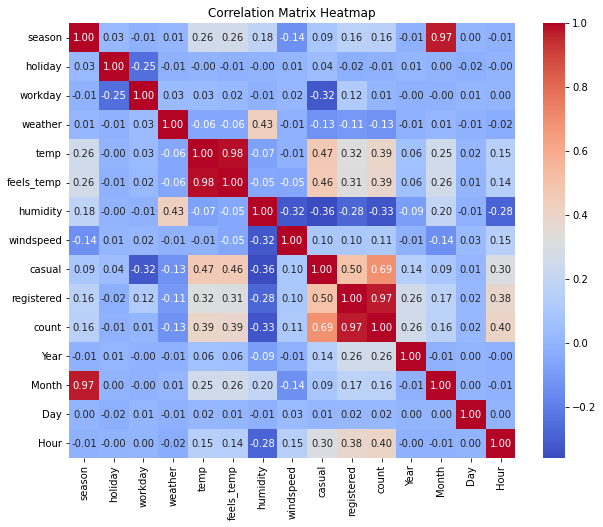

In [27]:
#Data Reduction
#Convert dataframe to Pandas to view correlation matirx
df_pd = df.toPandas()

correlation_matrix = df_pd.corr()

# Print correlation matrix
print("Correlation Matrix:")
print(correlation_matrix['count'])

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


In [28]:
#Drop Varaibles that are seen as to not have a high correlations with target variable "count"
df.show()

df = df.drop('holiday', 'workday', 'weather', 'humidity', 'Day')
df_reformated = df_reformated.drop('holiday', 'workday', 'weather', 'humidity', 'Day')

df.show()
df_reformated.show()


+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|season|holiday|workday|weather| temp|feels_temp|humidity|windspeed|casual|registered|count|Year|Month|Day|Hour|
+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|     1|  false|  false|      1|10.66|    11.365|      41|  19.9995|     0|        16|   16|2012|    3| 10|   3|
|     1|  false|  false|      1|10.66|    11.365|      44|  22.0028|    11|        20|   31|2011|    1|  2|  21|
|     1|  false|  false|      1|10.66|     12.12|      41|  16.9979|     9|        53|   62|2012|    3|  4|  22|
|     1|  false|  false|      1|10.66|     12.88|     100|   12.998|     3|        53|   56|2011|    2|  5|  21|
|     1|  false|  false|      1|10.66|     12.88|      41|   12.998|     6|        77|   83|2012|    3| 10|  23|
|     1|  false|  false|      1|10.66|     12.88|      41|  15.0013|     1|        39|   40|2011

<AxesSubplot:xlabel='count', ylabel='Count'>

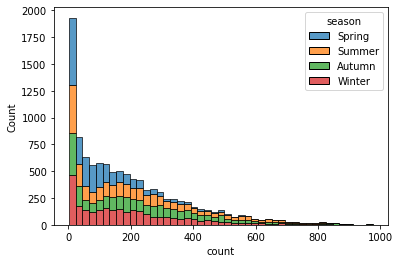

In [29]:
df_reformated = df_reformated.toPandas()

sns.histplot(data=df_reformated, x="count", hue="season", multiple="stack")

<AxesSubplot:xlabel='count', ylabel='Count'>

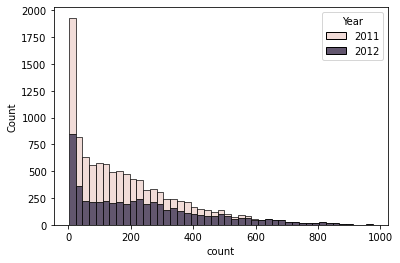

In [30]:
sns.histplot(data=df_reformated, x="count", hue="Year", multiple="stack")

<AxesSubplot:xlabel='count', ylabel='Count'>

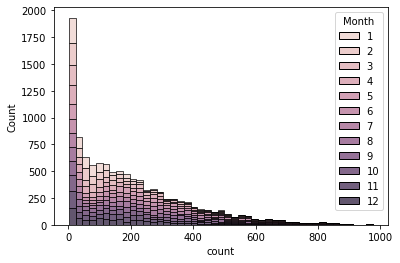

In [31]:
sns.histplot(data=df_reformated, x="count", hue="Month", multiple="stack")

# 05 - Data Mining Methods

To Identify in what factors in which consumers may or may not use bike-sharing services. 
In additon to understand the patterns in which these factors effect overall demand in order 
to provide better service for consumers. We will use Clustering and Regression  as the main methods. 

# 06 - Data Mining Method Analysis


### Classification Methods 
- Logistic regression

### Clustering Methods 
- K Means Clustering

### Regression Methods
- Linear Regression

#### Tree Methods
- Single Decision Tree
- Random Forest 
- Gradient Boosted ree Classifer 

# 07 - Data Mining


### K-MEANS CLUSTERING
#### PySpark

In [32]:
from pyspark.ml.clustering import KMeans
df.head(1)

df.printSchema()

root
 |-- season: integer (nullable = true)
 |-- temp: float (nullable = true)
 |-- feels_temp: float (nullable = true)
 |-- windspeed: float (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Hour: integer (nullable = true)



In [33]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType

df = df.withColumn("count", df["count"].cast(IntegerType()))

df.printSchema()

root
 |-- season: integer (nullable = true)
 |-- temp: float (nullable = true)
 |-- feels_temp: float (nullable = true)
 |-- windspeed: float (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Hour: integer (nullable = true)



In [34]:
feat_cols = ['season', 'temp', 'feels_temp', 'windspeed', 'casual', 'registered', 'count', 'Year', 'Month', 'Hour']

vec_assembler = VectorAssembler(inputCols = feat_cols, outputCol='features')

final_data = vec_assembler.transform(df)

from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
final_data

DataFrame[season: int, temp: float, feels_temp: float, windspeed: float, casual: int, registered: int, count: int, Year: int, Month: int, Hour: int, features: vector]

In [35]:
scalerModel = scaler.fit(final_data)
cluster_final_data = scalerModel.transform(final_data)

### Train and Evaluate Model

In [36]:
kmeans3 = KMeans(featuresCol='scaledFeatures',k=3)
kmeans2 = KMeans(featuresCol='scaledFeatures',k=2)

In [37]:
model3 = kmeans3.fit(cluster_final_data)
model2 = kmeans2.fit(cluster_final_data)

In [38]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Make predictions
predictions3 = model3.transform(cluster_final_data)
predictions2 = model2.transform(cluster_final_data)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette3 = evaluator.evaluate(predictions3)
print("With k=3 Silhouette with squared euclidean distance = " + str(silhouette3))

silhouette2 = evaluator.evaluate(predictions2)
print("With k=2 Silhouette with squared euclidean distance = " + str(silhouette2))

With k=3 Silhouette with squared euclidean distance = 0.03756345094103511
With k=2 Silhouette with squared euclidean distance = 0.043120280279549394


In [39]:
#RESULTS 
centers3 = model3.clusterCenters()
print("Cluster Centers for k=3:")
for center in centers3:
    print(center)

centers2 = model2.clusterCenters()
print("Cluster Centers for k=2:")
for center in centers2:
    print(center)

Cluster Centers for k=3:
[2.40904995e+00 3.46801256e+00 3.65898490e+00 1.75664598e+00
 1.68364618e+00 1.98439967e+00 2.11911971e+00 4.02314973e+03
 2.05247251e+00 2.19626900e+00]
[1.11429978e+00 1.68522423e+00 1.88360953e+00 1.80553727e+00
 2.37668952e-01 5.52327568e-01 5.26061706e-01 4.02279520e+03
 7.29285761e-01 1.60445185e+00]
[3.04120211e+00 2.58518316e+00 2.79052960e+00 1.31678089e+00
 2.86327403e-01 5.99787315e-01 5.79060348e-01 4.02276975e+03
 2.71017265e+00 1.25916241e+00]
Cluster Centers for k=2:
[1.18074118e+00 1.78734706e+00 1.98812797e+00 1.75460259e+00
 2.30813924e-01 5.25889290e-01 5.02129043e-01 4.02282884e+03
 8.13662589e-01 1.47564360e+00]
[2.79919620e+00 3.00695778e+00 3.20448630e+00 1.53075235e+00
 9.69108714e-01 1.28622909e+00 1.33981740e+00 4.02293555e+03
 2.44948378e+00 1.76054442e+00]


In [40]:
# Evaluate clustering by computing Within Set Sum of Squared Errors.
for k in range(2,9):
    kmeans = KMeans(featuresCol='scaledFeatures',k=k)
    model = kmeans.fit(cluster_final_data)
    predictions = model.transform(cluster_final_data)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print("With K={}".format(k))
    print("Silhouette with squared euclidean distance = " + str(silhouette))
    print('--'*30)

With K=2
Silhouette with squared euclidean distance = 0.043120280279549394
------------------------------------------------------------
With K=3
Silhouette with squared euclidean distance = 0.03756345094103511
------------------------------------------------------------
With K=4
Silhouette with squared euclidean distance = 0.005666470952404589
------------------------------------------------------------
With K=5
Silhouette with squared euclidean distance = 0.012519835045153756
------------------------------------------------------------
With K=6
Silhouette with squared euclidean distance = -0.05104286276522297
------------------------------------------------------------
With K=7
Silhouette with squared euclidean distance = -0.1542182407013984
------------------------------------------------------------
With K=8
Silhouette with squared euclidean distance = -0.16934635201876097
------------------------------------------------------------


In [41]:
model3.transform(cluster_final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 3253|
|         2| 4069|
|         0| 3476|
+----------+-----+



In [42]:
model2.transform(cluster_final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 7186|
|         0| 3612|
+----------+-----+



### Linear Regression
#### PySpark

In [43]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# Initialize Spark session
spark = SparkSession.builder.appName('lr_example').getOrCreate()

data = df

# Show the data
data.show()

# Print the schema of the DataFrame
data.printSchema()

+------+-----+----------+---------+------+----------+-----+----+-----+----+
|season| temp|feels_temp|windspeed|casual|registered|count|Year|Month|Hour|
+------+-----+----------+---------+------+----------+-----+----+-----+----+
|     1|10.66|    11.365|  19.9995|     0|        16|   16|2012|    3|   3|
|     1|10.66|    11.365|  22.0028|    11|        20|   31|2011|    1|  21|
|     1|10.66|     12.12|  16.9979|     9|        53|   62|2012|    3|  22|
|     1|10.66|     12.88|   12.998|     3|        53|   56|2011|    2|  21|
|     1|10.66|     12.88|   12.998|     6|        77|   83|2012|    3|  23|
|     1|10.66|     12.88|  15.0013|     1|        39|   40|2011|    2|  20|
|     1|10.66|     12.88|  11.0014|    19|        81|  100|2012|    3|  22|
|     1|10.66|     12.88|  15.0013|     0|         1|    1|2011|    2|   5|
|     1|10.66|     12.88|  15.0013|     0|         1|    1|2011|    2|   6|
|     1|10.66|     12.88|   12.998|     2|        37|   39|2011|    2|   0|
|     1|10.6

In [44]:
data.columns

['season',
 'temp',
 'feels_temp',
 'windspeed',
 'casual',
 'registered',
 'count',
 'Year',
 'Month',
 'Hour']

In [45]:
# Define input columns and assembler
input_cols = ["season", "temp", "feels_temp", "windspeed", "casual", "registered", "Year", "Month", "Hour"]
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")


output = assembler.transform(data)
output.select("features").show(3)

output.head(1)

+--------------------+
|            features|
+--------------------+
|[1.0,10.659999847...|
|[1.0,10.659999847...|
|[1.0,10.659999847...|
+--------------------+
only showing top 3 rows



[Row(season=1, temp=10.65999984741211, feels_temp=11.364999771118164, windspeed=19.999500274658203, casual=0, registered=16, count=16, Year=2012, Month=3, Hour=3, features=DenseVector([1.0, 10.66, 11.365, 19.9995, 0.0, 16.0, 2012.0, 3.0, 3.0]))]

In [46]:
final_data = output.select("features", "count")

In [47]:
# Print schema and show final data
final_data.printSchema()
final_data.show()

root
 |-- features: vector (nullable = true)
 |-- count: integer (nullable = true)

+--------------------+-----+
|            features|count|
+--------------------+-----+
|[1.0,10.659999847...|   16|
|[1.0,10.659999847...|   31|
|[1.0,10.659999847...|   62|
|[1.0,10.659999847...|   56|
|[1.0,10.659999847...|   83|
|[1.0,10.659999847...|   40|
|[1.0,10.659999847...|  100|
|[1.0,10.659999847...|    1|
|[1.0,10.659999847...|    1|
|[1.0,10.659999847...|   39|
|[1.0,10.659999847...|    7|
|[1.0,10.659999847...|   34|
|[1.0,10.659999847...|  205|
|[1.0,10.659999847...|   40|
|[1.0,10.659999847...|   16|
|[1.0,10.659999847...|   51|
|[1.0,10.659999847...|   62|
|[1.0,11.479999542...|  101|
|[1.0,11.479999542...|   91|
|[1.0,11.479999542...|   88|
+--------------------+-----+
only showing top 20 rows



### Train Model

In [48]:
#Split data to training and test: 

train, test = final_data.randomSplit([0.7,0.3])

train.describe().show()
test.describe().show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|              7514|
|   mean|193.65184988022358|
| stddev|181.96673638454936|
|    min|                 1|
|    max|               977|
+-------+------------------+

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|              3284|
|   mean|188.35505481120586|
| stddev|179.88565428051103|
|    min|                 1|
|    max|               943|
+-------+------------------+



In [49]:
lr = LinearRegression(labelCol='count')

lrModel = lr.fit(train)

24/05/24 17:43:45 WARN Instrumentation: [0319c0bf] regParam is zero, which might cause numerical instability and overfitting.
24/05/24 17:43:46 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/24 17:43:46 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
24/05/24 17:43:46 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [50]:
# Print the coefficients and intercept for linear regression
print("Coefficients: {}".format(str(lrModel.coefficients)))
print("Intercept: {}".format(str(lrModel.intercept)))

Coefficients: [1.8766151326653306e-12,-2.4838970426988248e-12,2.946734902437655e-12,1.186013774242813e-12,0.9999999999997877,0.999999999999626,3.641183163244693e-10,2.358140577040684e-12,3.5782336445290507e-12]
Intercept: -7.324533178648069e-07


In [51]:
# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
trainingSummary.residuals.show()

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+--------------------+
|           residuals|
+--------------------+
|-1.86490378695225...|
|-1.74090075688582...|
|-1.90616855633152...|
|-1.45405465445946...|
|-8.61177795741241...|
|-1.83535409092883...|
|-1.38498990054358...|
|1.790747550245441...|
|-1.79468884198286...|
|1.716919939553918...|
|1.982982666959287...|
|1.689702822105232...|
|-1.98301819409607...|
|1.908375679704477...|
|9.875122941593872...|
|1.685940276274777...|
|1.565201301900742...|
|-1.95377936051954...|
|-1.32473587655113...|
|1.805897653639476...|
+--------------------+
only showing top 20 rows



In [52]:
# Evaluate the model on the test data
test_results = lrModel.evaluate(test)
test_results.residuals.show()

+--------------------+
|           residuals|
+--------------------+
|-1.89707805020589...|
|-2.01403338451200...|
|-1.96934024643269...|
|-2.11872741573415...|
|-1.83295156830354...|
|1.637192603709536...|
|1.825668505262001...|
|1.603089883062125...|
|-2.30244268095702...|
|2.355875494686188...|
|1.843432073656004...|
|-2.01623606699286...|
|-1.84090964694405...|
|-1.95882421394344...|
|1.805231519824701...|
|-2.04313010954138...|
|2.200124527007574...|
|-1.88092874608969...|
|-4.72937244921922...|
|1.708908570208223...|
+--------------------+
only showing top 20 rows



In [53]:
# Print RMSE and R2 values
print("RMSE: {}".format(test_results.rootMeanSquaredError))
print("R2: {}".format(test_results.r2))

RMSE: 1.7473511053796753e-10
R2: 1.0


In [54]:
# Describe the final data
final_data.describe().show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|             10798|
|   mean|192.04093350620485|
| stddev|181.34439439189487|
|    min|                 1|
|    max|               977|
+-------+------------------+



In [55]:
#Cross-Validation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Define the linear regression model
lr = LinearRegression(labelCol='count')

# Create a parameter grid for cross-validation (if needed)
paramGrid = ParamGridBuilder().build()

# Define the cross-validator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol='count'),
                          numFolds=5)  # Use 5-fold cross-validation

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(final_data)

# Get the best model from cross-validation
bestModel = cvModel.bestModel

# Evaluate the best model on the test data
test_results_cv = bestModel.evaluate(test)
print("Cross-Validated RMSE: {}".format(test_results_cv.rootMeanSquaredError))
print("Cross-Validated R2: {}".format(test_results_cv.r2))



24/05/24 17:43:48 WARN Instrumentation: [dad61d49] regParam is zero, which might cause numerical instability and overfitting.
24/05/24 17:43:49 WARN Instrumentation: [82b212d8] regParam is zero, which might cause numerical instability and overfitting.
24/05/24 17:43:50 WARN Instrumentation: [30ba596c] regParam is zero, which might cause numerical instability and overfitting.
24/05/24 17:43:51 WARN Instrumentation: [11c94256] regParam is zero, which might cause numerical instability and overfitting.
24/05/24 17:43:52 WARN Instrumentation: [50100af1] regParam is zero, which might cause numerical instability and overfitting.
24/05/24 17:43:53 WARN Instrumentation: [0a1986af] regParam is zero, which might cause numerical instability and overfitting.


Cross-Validated RMSE: 8.877367815187351e-12
Cross-Validated R2: 1.0


# 08 - Interpretation


#### K-means Clustering

In [56]:
viz_cols = feat_cols + ['prediction']

pdf3 = predictions3.select(viz_cols).toPandas()
pdf2 = predictions2.select(viz_cols).toPandas()

centers3_df = pd.DataFrame(model3.clusterCenters(), columns=feat_cols)
centers2_df = pd.DataFrame(model2.clusterCenters(), columns=feat_cols)

def plot_clusters(data, centers, k, feature):
    plt.figure(figsize=(20, 10))
    sns.scatterplot(x=feature, y='count', hue='predictIion', data=data, palette='viridis')
    #plt.scatter(centers[feature], centers['count'], s=300, c='red', marker='X')
    plt.title(f'K-means Clustering (k={k}) - {feature} vs Count')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Count')
    plt.show()
    

# Plot pair plot for k=3
plt.figure(figsize=(15, 15))
sns.pairplot(pdf3, hue='prediction', palette='viridis')
plt.suptitle('Pair Plot of Features (k=3)', y=1.02)
plt.show()

# Plot pair plot for k=2
plt.figure(figsize=(15, 15))
sns.pairplot(pdf2, hue='prediction', palette='viridis')
plt.suptitle('Pair Plot of Features (k=2)', y=1.02)
plt.show()

In [57]:
def plot_distribution(data, k):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='season', y='count', hue='prediction', data=data, palette='viridis')
    plt.title(f'Distribution of Count across Seasons (k={k})')
    plt.xlabel('Season')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='season', y='count', hue='prediction', data=data, palette='viridis')
    plt.title(f'Distribution of Count across Seasons (k={k})')
    plt.xlabel('Season')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.show()
    
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Year', y='count', hue='prediction', data=data, palette='viridis')
    plt.title(f'Distribution of Count across Seasons (k={k})')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='Year', y='count', hue='prediction', data=data, palette='viridis')
    plt.title(f'Distribution of Count across Seasons (k={k})')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.show()
    
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Month', y='count', hue='prediction', data=data, palette='viridis')
    plt.title(f'Distribution of Count across Seasons (k={k})')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='Month', y='count', hue='prediction', data=data, palette='viridis')
    plt.title(f'Distribution of Count across Seasons (k={k})')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.show()
    
    plt.figure(figsize=(20, 12))
    sns.boxplot(x='Hour', y='count', hue='prediction', data=data, palette='viridis')
    plt.title(f'Distribution of Count across Seasons (k={k})')
    plt.xlabel('Hour')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.show()
    
    plt.figure(figsize=(20, 12))
    sns.violinplot(x='Hour', y='count', hue='prediction', data=data, palette='viridis')
    plt.title(f'Distribution of Count across Seasons (k={k})')
    plt.xlabel('Hour')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.show()

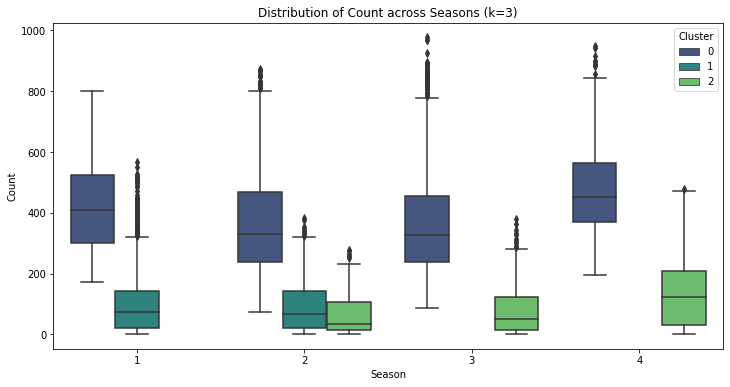

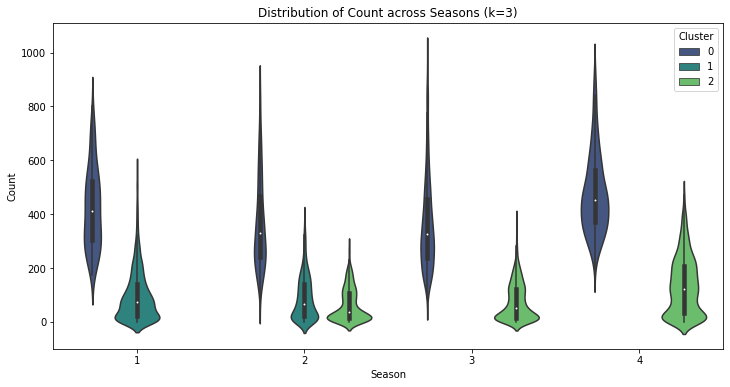

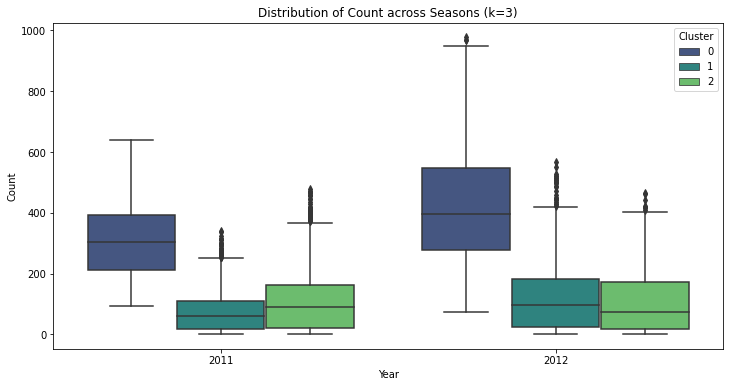

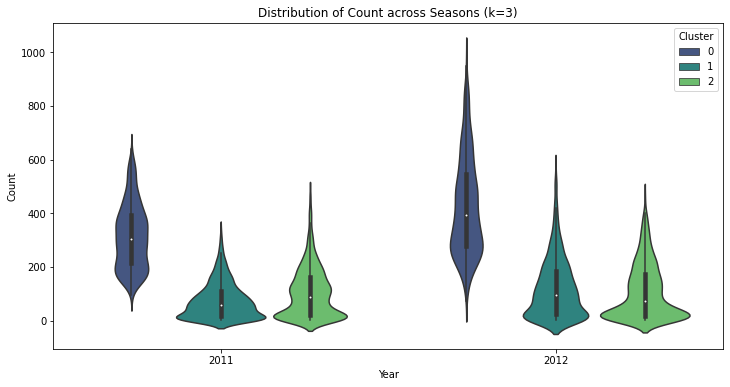

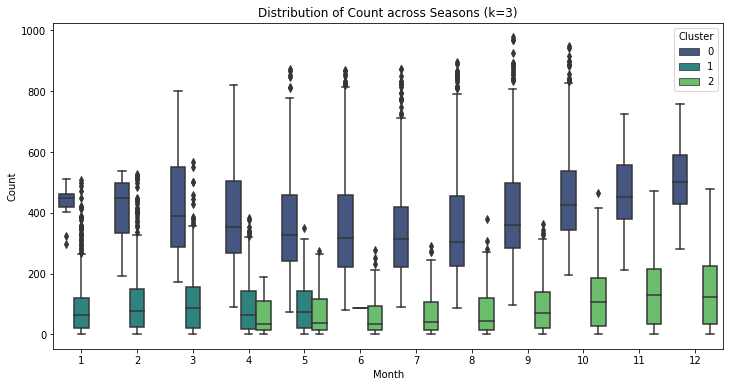

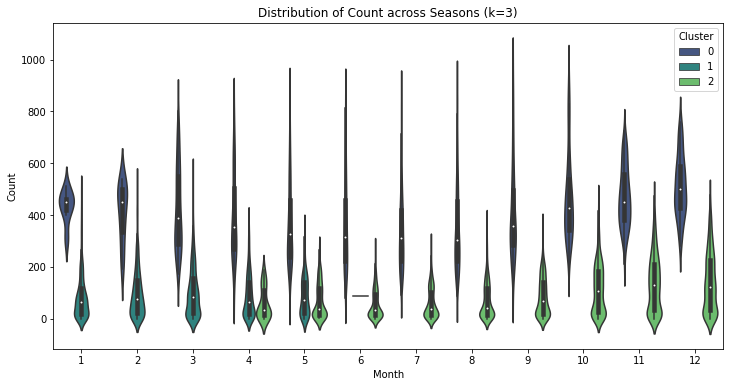

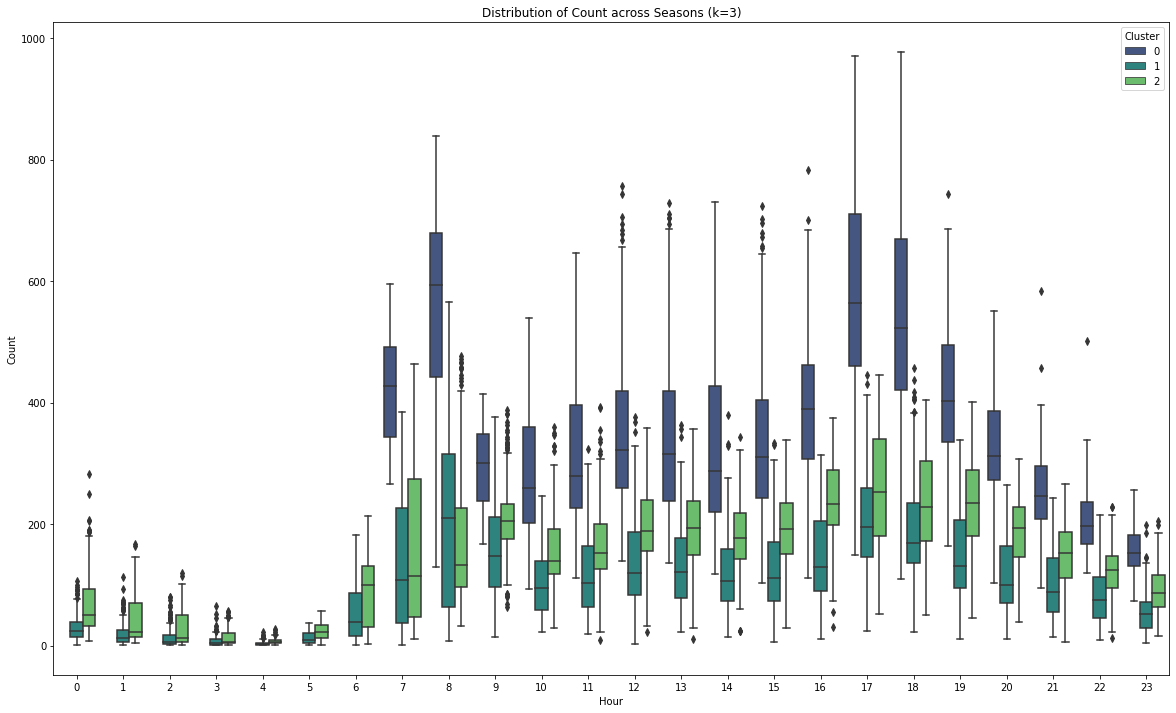

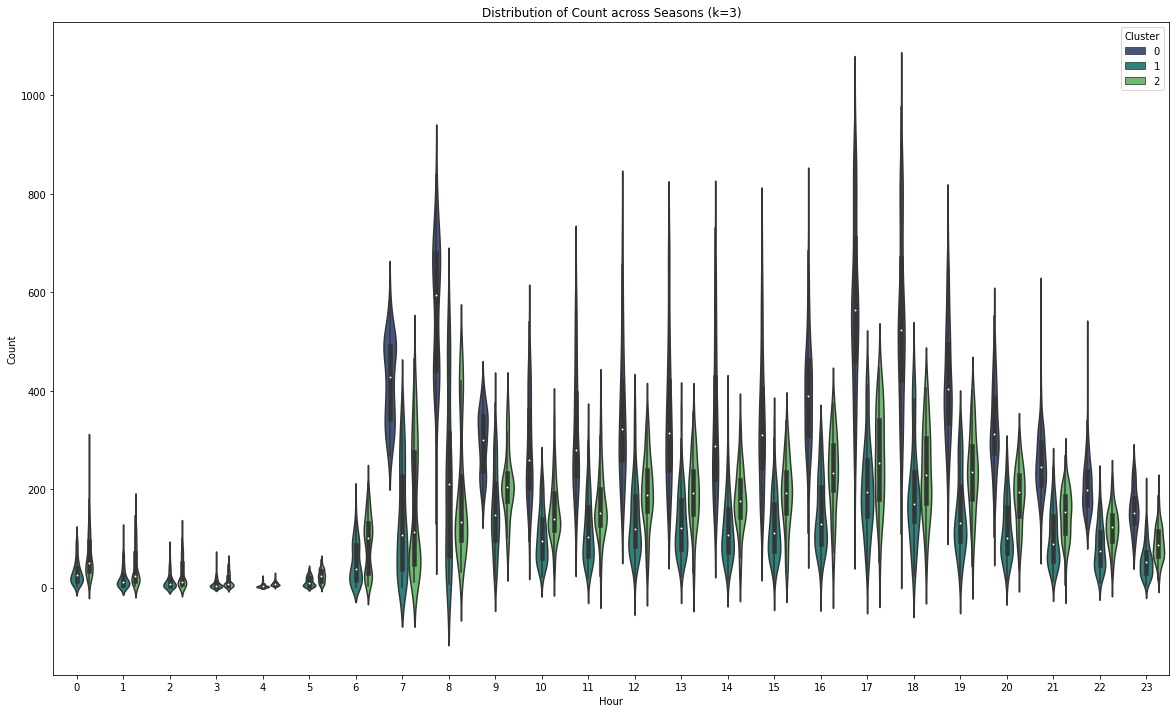

In [58]:
plot_distribution(pdf3, 3)

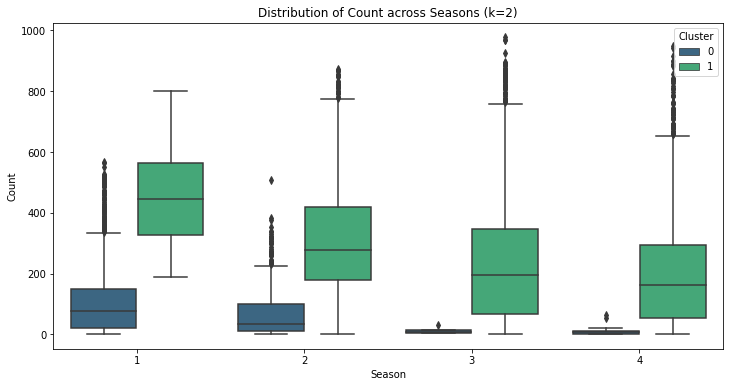

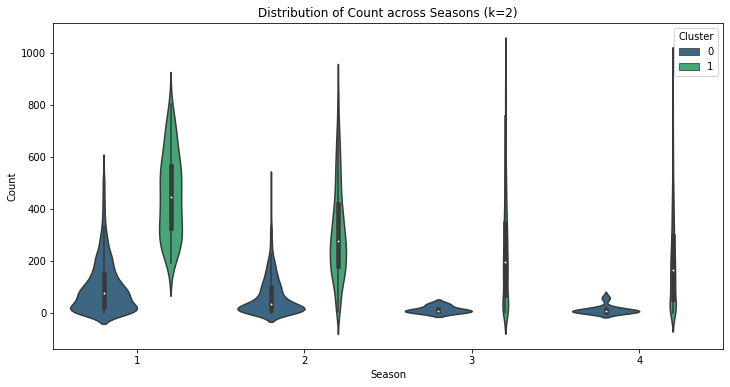

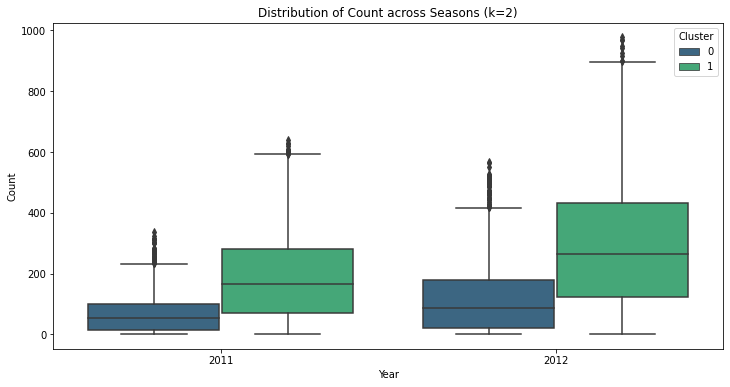

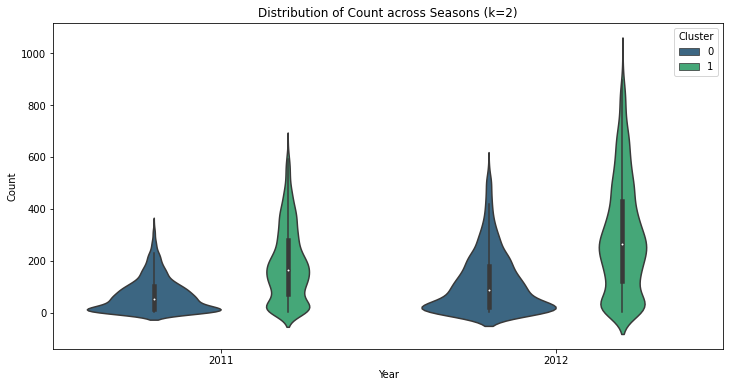

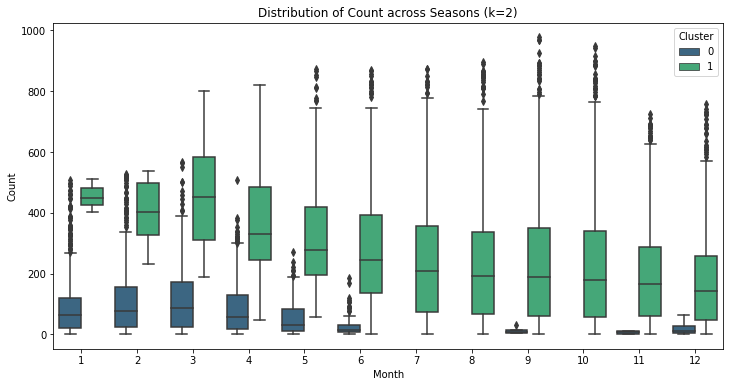

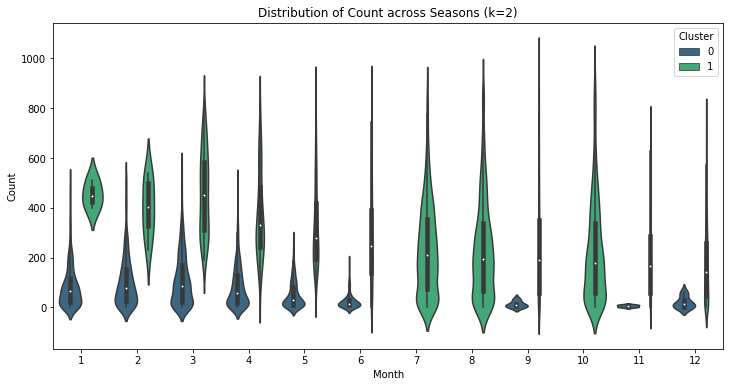

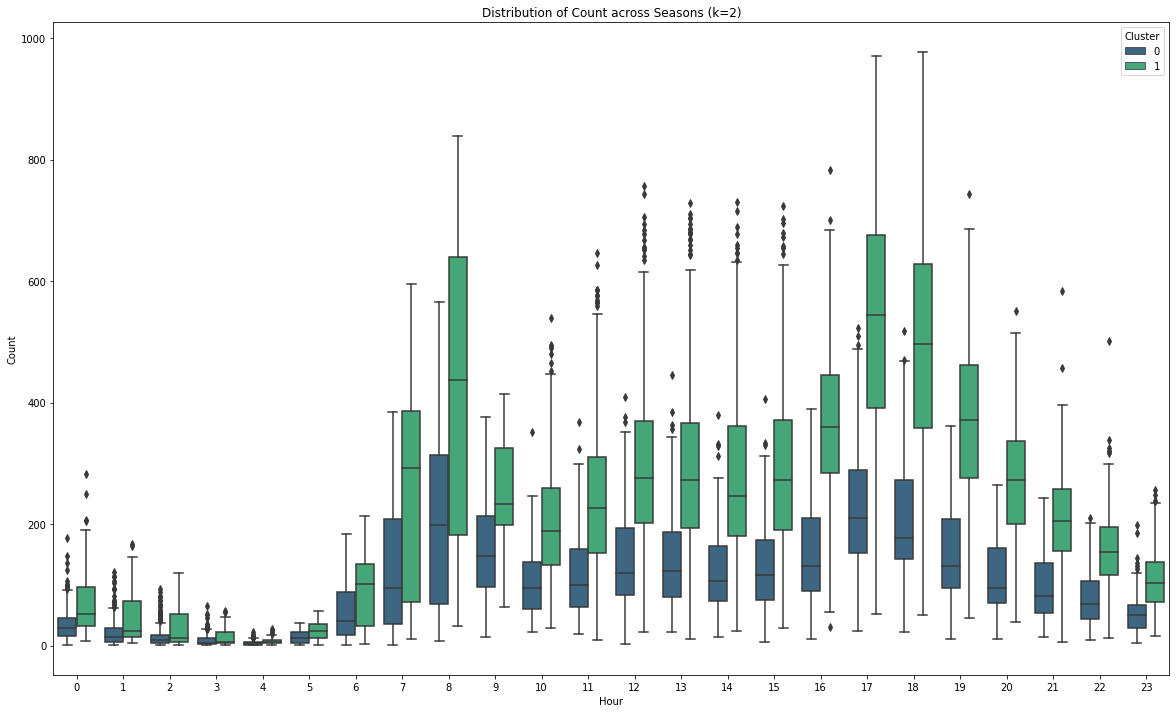

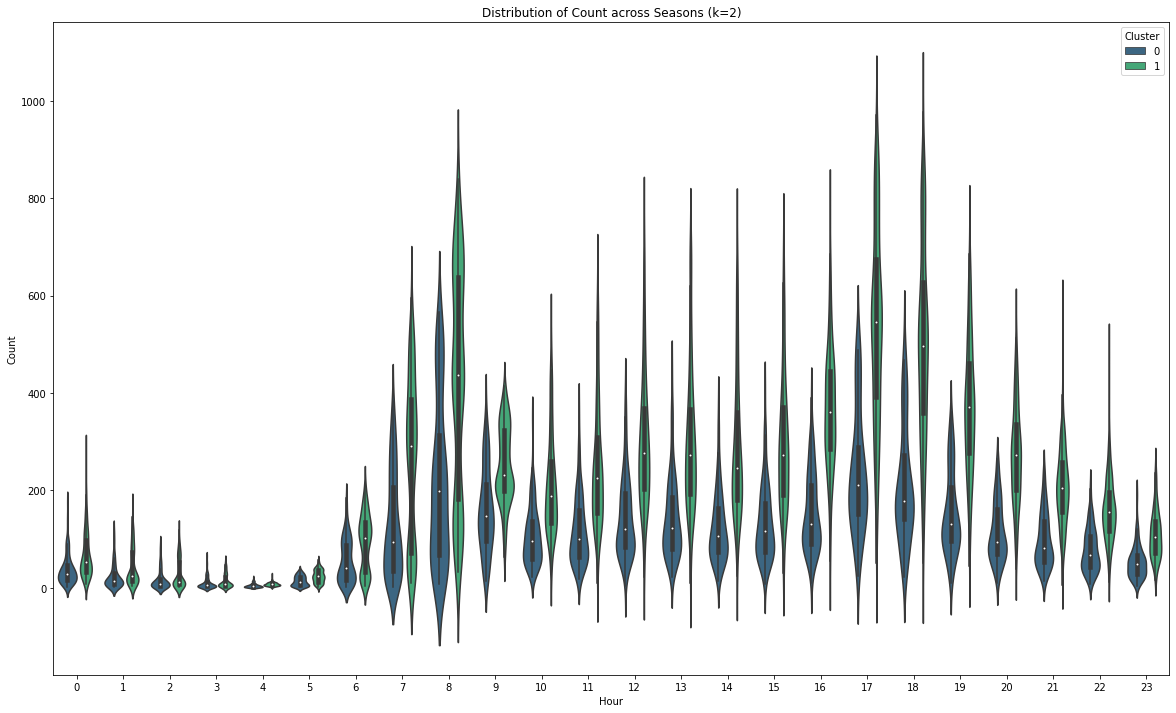

In [59]:
plot_distribution(pdf2, 2)

In [60]:
def plot_scatter_clusters_all(data, k, cols):
    # Plot scatter plots for specified columns
    for col in cols:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=col, y='count', hue='prediction', data=data, palette='viridis')
        plt.title(f'Scatter Plot of {col.capitalize()} vs Count (k={k})')
        plt.xlabel(col.capitalize())
        plt.ylabel('Count')
        plt.legend(title='Cluster')
        plt.show()

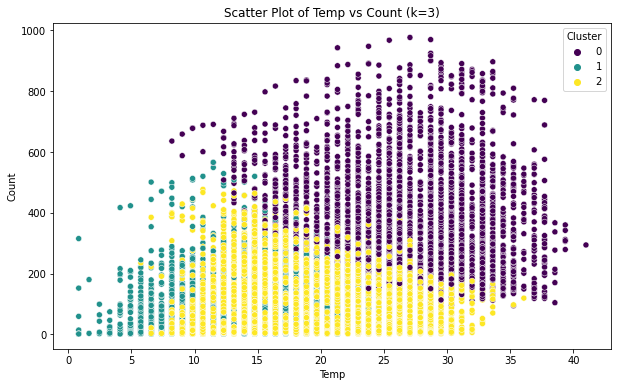

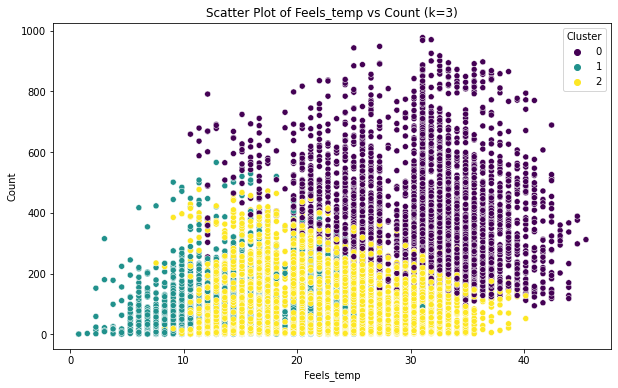

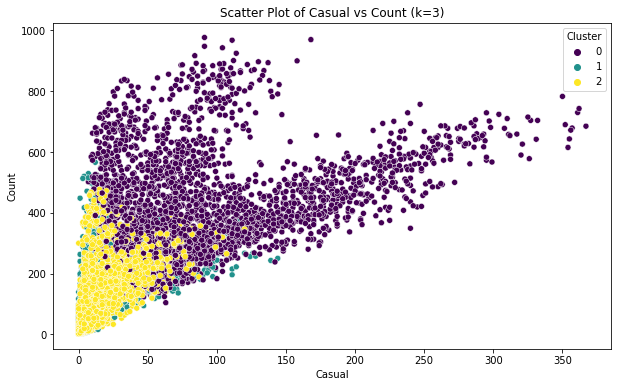

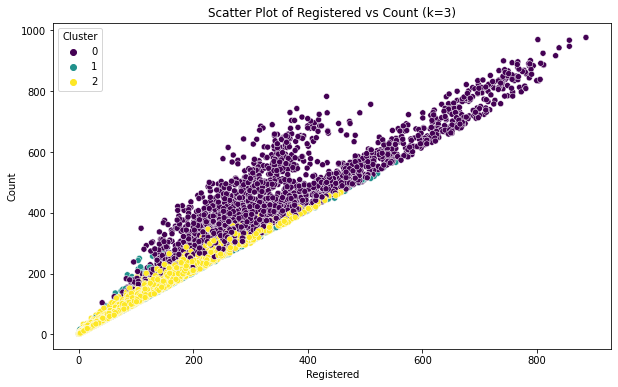

In [61]:
# Plot scatter plots for k=3
plot_scatter_clusters_all(pdf3, 3, ['temp', 'feels_temp', 'casual', 'registered'])

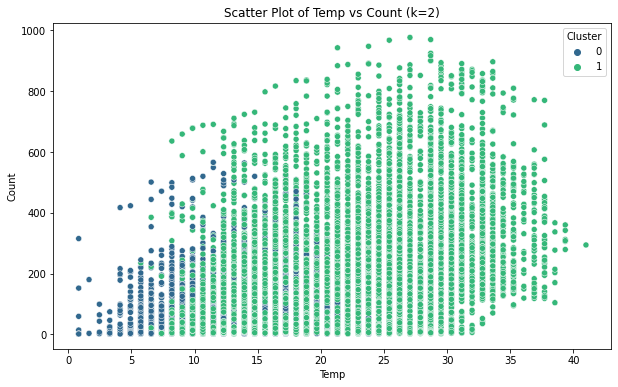

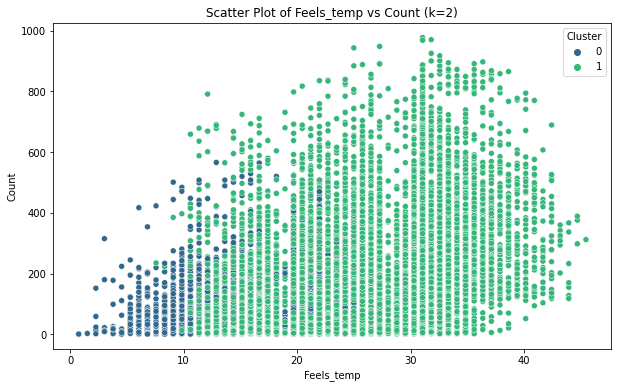

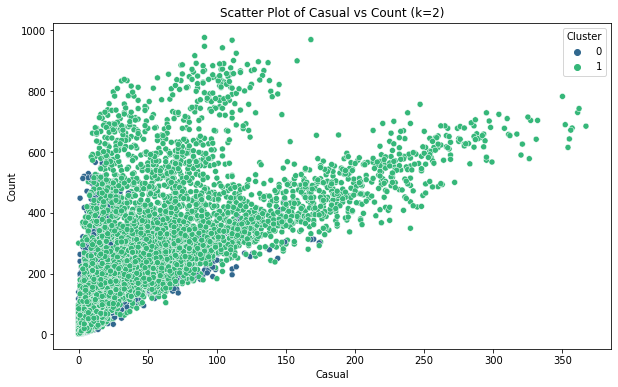

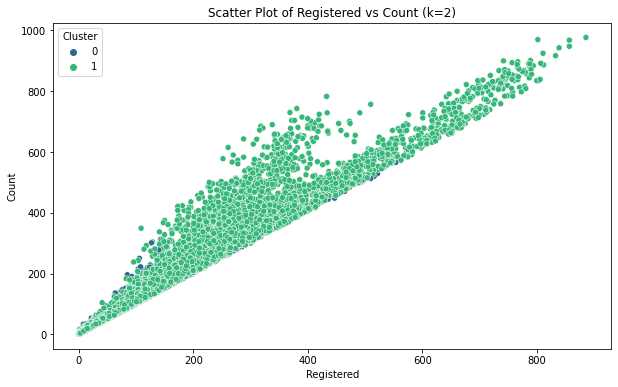

In [62]:
# Plot scatter plots for k=2
plot_scatter_clusters_all(pdf2, 2, ['temp', 'feels_temp', 'casual', 'registered'])

#### Linear Regression

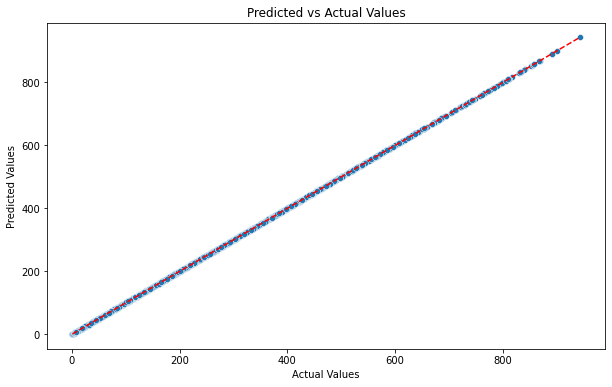

In [63]:
#Inspect Model Results

import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
predictions = bestModel.transform(test)

# Collect predicted and actual values to the local environment for plotting
predictions_pd = predictions.select("prediction", "count").toPandas()

# Plot predicted vs. actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions_pd['count'], y=predictions_pd['prediction'])
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.plot([predictions_pd['count'].min(), predictions_pd['count'].max()],
         [predictions_pd['count'].min(), predictions_pd['count'].max()],
         color='red', linestyle='--')  # Line y=x for reference
plt.show()


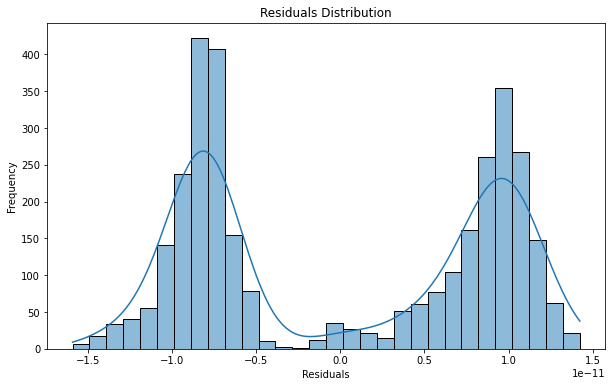

In [64]:
# Residuals Plot
residuals = predictions_pd['count'] - predictions_pd['prediction']
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

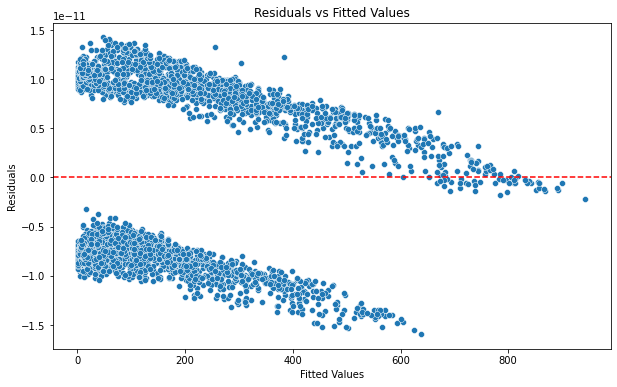

In [65]:
# Residuals vs. Fitted Values Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions_pd['prediction'], y=residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.axhline(0, color='red', linestyle='--')
plt.show()

<Figure size 720x432 with 0 Axes>

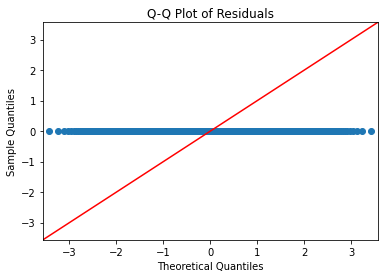

In [66]:
# Q-Q Plot of Residuals
import numpy as np
import statsmodels.api as sm

plt.figure(figsize=(10, 6))
sm.qqplot(np.array(residuals), line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

Iteration